In [93]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

!date
!whoami
!pwd

Thu Oct 23 10:10:42 PDT 2025
abie
/mnt/share/homes/abie/notebook/2025


In [94]:
age_mapping = pd.read_csv(f'data/age_bins.csv')  # downloaded with a different environment
                                                # using vivarium_inputs.utility_data.get_age_bins;
                                                # see also https://shiny.ihme.washington.edu/content/273/
                                                # TODO: refactor this so that it does not require an extra .csv file
age_mapping

,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
0,5,5,0 to 5,0.0,5.0
1,6,6,5 to 9,5.0,10.0
2,7,7,10 to 14,10.0,15.0
3,8,8,15 to 19,15.0,20.0
4,9,9,20 to 24,20.0,25.0
5,10,10,25 to 29,25.0,30.0
6,11,11,30 to 34,30.0,35.0
7,12,12,35 to 39,35.0,40.0
8,13,13,40 to 44,40.0,45.0
9,14,14,45 to 49,45.0,50.0


## V&V List from Docs 

    - Verify that all simulants in the model have AD (i.e., all recorded person-time is in one of the “AD” states, not the “susceptible” state)
    - Verify that there are simulant person-years of BBBM-AD, MCI-AD, and AD-dementia for every year and age group of simulation
    - Verify that there are transitions between AD states are at the expected rates
    - Verify other sim mortality against artifact (ACMR - CSMR)
    - Verify Alzheimer’s EMR against artifact
    - Verify the number of new AD-demential cases per year against the AD population model

# Load Data

In [95]:
# %cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

In [96]:
locations = [
#     'united_states_of_america',
#              'china',
#              'brazil',
#              'japan',
             'sweden',
#              'united_kingdom',
            ]



results_dirs = [
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/abie_consistent_model_test/sweden/2025_10_22_15_47_41/results/'
]

artifact_dirs = ['/mnt/share/homes/abie/projects/2025/vivarium_csu_alzheimers/sweden.hdf']
artifact_dirs

['/mnt/share/homes/abie/projects/2025/vivarium_csu_alzheimers/sweden.hdf']

In [97]:
[x for x in os.listdir(results_dirs[0]) if 'parquet' in x]

['counts_newly_eligible_for_bbbm_testing.parquet',
 'deaths.parquet',
 'counts_new_simulants.parquet',
 'ylls.parquet',
 'person_time_eligible_for_bbbm_testing.parquet',
 'transition_count_alzheimers_disease_and_other_dementias.parquet',
 'transition_count_treatment.parquet',
 'ylds.parquet',
 'counts_bbbm_tests.parquet',
 'person_time_treatment.parquet',
 'person_time_alzheimers_disease_and_other_dementias.parquet',
 'person_time_ever_eligible_for_bbbm_testing.parquet',
 'counts_baseline_tests_among_eligible.parquet']

In [98]:
# age_group_ids = [11,12,13,14,15,16,17,18,19,20,30,31,32,33]
# art = Artifact(artifact_dirs[0],
#                filter_terms = ['year_start==2021']  # FIXME: make this work even without filter_terms
#               )

# age_dictionary = pd.DataFrame()
# age_dictionary['age_group_id'] = age_group_ids
# age_dictionary = age_dictionary.merge(get_ids('age_group'), on='age_group_id')
# age_dictionary['age_group'] = age_dictionary.age_group_name.str.lower().str.replace(' ', '_')
# artifact = art.load('population.structure').reset_index()
# artifact = artifact.loc[artifact.age_start > 29].reset_index()
# age_dictionary['age_start'] = artifact.age_start
# age_dictionary['age_end'] = artifact.age_end

# # tweak final row to be named age group 95_plus
# assert age_dictionary.loc[13, 'age_group'] == '95_to_99'
# age_dictionary.loc[13, 'age_group'] = '95_plus'

# age_dictionary.tail()

age_dictionary = age_mapping.copy()
age_dictionary['age_group'] = age_dictionary.age_group_name.str.lower().str.replace(' ', '_')
age_dictionary

,Unnamed: 0,age_group_id,age_group_name,age_start,age_end,age_group
0,5,5,0 to 5,0.0,5.0,0_to_5
1,6,6,5 to 9,5.0,10.0,5_to_9
2,7,7,10 to 14,10.0,15.0,10_to_14
3,8,8,15 to 19,15.0,20.0,15_to_19
4,9,9,20 to 24,20.0,25.0,20_to_24
5,10,10,25 to 29,25.0,30.0,25_to_29
6,11,11,30 to 34,30.0,35.0,30_to_34
7,12,12,35 to 39,35.0,40.0,35_to_39
8,13,13,40 to 44,40.0,45.0,40_to_44
9,14,14,45 to 49,45.0,50.0,45_to_49


In [99]:
age_group_ids = age_dictionary.query('age_start >= 30 and age_start <= 95').age_group_id.values

## Verify that all simulants in the model have AD 

In [154]:
def load_df(measure):
    data = pd.DataFrame()
#     import pdb; pdb.set_trace()
    for results_dir in results_dirs:
        temp = pd.read_parquet(results_dir + measure + '.parquet',
#                                filters=[('artifact_path', '==', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf')],
#                                nrows=1000
                              )
        # just look at the baseline scenario for v&v purposes
        temp = temp[temp.scenario == 'baseline']
        
        # aggregate by summing value column over random seeds
#         print(temp.columns)
#         import pdb; pdb.set_trace()
        cols = [c for c in temp.columns if c not in ['value', 'random_seed', 'treatment', 'artifact_path']]
        temp = temp.groupby(cols)['value'].sum().reset_index()
        
        temp['location'] = locations[results_dirs.index(results_dir)].title()
        temp['event_year'] = temp['event_year'].astype(int)
        data = pd.concat([data, temp], ignore_index=True)
    return data

In [155]:
person_time = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time

/tmp/ipykernel_1137157/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()


,measure,entity_type,entity,sub_entity,age_group,event_year,sex,input_draw_number,scenario,input_draw,value,location
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,2,baseline,2,0.000000,Sweden
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,2,baseline,13,0.000000,Sweden
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,2,baseline,24,0.000000,Sweden
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,2,baseline,41,0.000000,Sweden
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,2,baseline,46,0.000000,Sweden
...,...,...,...,...,...,...,...,...,...,...,...,...
4274995,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2100,Male,499,baseline,446,0.000000,Sweden
4274996,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2100,Male,499,baseline,457,0.000000,Sweden
4274997,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2100,Male,499,baseline,460,0.000000,Sweden
4274998,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2100,Male,499,baseline,480,0.000000,Sweden


In [156]:
person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum()

0.0

In [157]:
assert person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero years of person-time susceptible'

# Verify that there *are* simulants in BBBM-AD and MCI-AD for all ages and years

In [158]:
person_time.groupby('sub_entity').value.sum()

/tmp/ipykernel_1137157/1434696413.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time.groupby('sub_entity').value.sum()


sub_entity
alzheimers_blood_based_biomarker_state        8.966350e+07
alzheimers_disease_state                      1.446346e+08
alzheimers_mild_cognitive_impairment_state    6.970264e+07
Name: value, dtype: float64

In [159]:
person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()

/tmp/ipykernel_1137157/63004212.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()


sub_entity                     alzheimers_blood_based_biomarker_state  \
location event_year age_group                                           
Sweden   2025       25_to_29                                 0.000000   
                    30_to_34                              1119.655031   
                    35_to_39                              1594.026010   
                    40_to_44                              1627.411362   
                    45_to_49                              4752.180698   
...                                                               ...   
         2100       75_to_79                            261627.553730   
                    80_to_84                            296965.201916   
                    85_to_89                            211565.470226   
                    90_to_94                            103283.318275   
                    95_plus                              38204.303901   

sub_entity                     alzheimers_disease_state  \
location event_year age_group                             
Sweden   2025       25_to_29                   0.000000   
                    30_to_34                  51.822040   
                    35_to_39                  39.863107   
                    40_to_44                  37.869952   
                    45_to_49                 101.152635   
...                                                 ...   
         2100       75_to_79              297944.837782   
                    80_to_84              489733.223819   
                    85_to_89              545061.223819   
                    90_to_94              365096.235455   
                    95_plus               210322.737851   

sub_entity                     alzheimers_mild_cognitive_impairment_state  
location event_year age_group                                              
Sweden   2025       25_to_29                                     0.000000  
                    30_to_34                                   978.639288  
                    35_to_39                                   661.229295  
                    40_to_44                                   625.850787  
                    45_to_49                                  1478.422998  
...                                                                   ...  
         2100       75_to_79                                180946.617385  
                    80_to_84                                234980.561259  
                    85_to_89                                193917.075975  
                    90_to_94                                105190.767967  
                    95_plus                                  46006.510609  

[1140 rows x 3 columns]

In [ ]:
assert np.all(person_time[~person_time.age_group.isin(['25_to_29', '30_to_34', '35_to_40'])
                         ].groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack().fillna(0) > 0)

## Verify that there are no transitions out of susceptible state during the simulation 

In [160]:
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum()

/tmp/ipykernel_1137157/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()


0.0

In [ ]:
assert trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero transitions from susceptible to with-condition'

# And that there *are* transitions out of other states for all ages

In [ ]:
assert np.all(trans.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack() > 0)

## Next look at the transition rates and approximate durations for BBBM and MCI

In [161]:
out_counts = trans.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()
out_counts.columns = [c.split('_to_')[0] for c in out_counts.columns]
out_counts

/tmp/ipykernel_1137157/3544767031.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out_counts = trans.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()


alzheimers_blood_based_biomarker_state  \
location event_year age_group                                           
Sweden   2025       25_to_29                                      0.0   
                    30_to_34                                    163.0   
                    35_to_39                                    205.0   
                    40_to_44                                    235.0   
                    45_to_49                                    677.0   
...                                                               ...   
         2100       75_to_79                                  38377.0   
                    80_to_84                                  45535.0   
                    85_to_89                                  33018.0   
                    90_to_94                                  15790.0   
                    95_plus                                    6068.0   

                               alzheimers_mild_cognitive_impairment_state  
location event_year age_group                                              
Sweden   2025       25_to_29                                          0.0  
                    30_to_34                                        229.0  
                    35_to_39                                        161.0  
                    40_to_44                                        170.0  
                    45_to_49                                        389.0  
...                                                                   ...  
         2100       75_to_79                                      46779.0  
                    80_to_84                                      59889.0  
                    85_to_89                                      48791.0  
                    90_to_94                                      25172.0  
                    95_plus                                       10751.0  

[1140 rows x 2 columns]

In [162]:
out_rates = out_counts / person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()
out_rates['alzheimers_blood_based_biomarker_state'].unstack()

/tmp/ipykernel_1137157/3571420227.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out_rates = out_counts / person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()


age_group            25_to_29  30_to_34  35_to_39  40_to_44  45_to_49  \
location event_year                                                     
Sweden   2025             NaN  0.145581  0.128605  0.144401  0.142461   
         2026             NaN  0.174510  0.160011  0.138284  0.159147   
         2027             NaN  0.218351  0.176137  0.141900  0.152175   
         2028             NaN  0.155974  0.183943  0.143897  0.155955   
         2029             NaN  0.244314  0.198288  0.126501  0.154605   
...                       ...       ...       ...       ...       ...   
         2096             NaN       NaN       NaN  0.120521  0.160513   
         2097             NaN       NaN  0.000000  0.120664  0.148126   
         2098             NaN       NaN  0.000000  0.122863  0.150938   
         2099             NaN       NaN  0.286695  0.120792  0.158451   
         2100             NaN       NaN  0.000000  0.141353  0.153181   

age_group            50_to_54  55_to_59  60_to_64  65_to_69  70_to_74  \
location event_year                                                     
Sweden   2025        0.147451  0.150623  0.146093  0.145760  0.146334   
         2026        0.158491  0.149449  0.139968  0.145072  0.147917   
         2027        0.163195  0.149512  0.145075  0.143898  0.148338   
         2028        0.164894  0.153846  0.141989  0.141660  0.147317   
         2029        0.168358  0.147642  0.138958  0.140925  0.145824   
...                       ...       ...       ...       ...       ...   
         2096        0.166618  0.139374  0.138389  0.144196  0.145502   
         2097        0.154723  0.145370  0.142727  0.141358  0.146190   
         2098        0.162269  0.150984  0.136722  0.141542  0.142794   
         2099        0.159598  0.145973  0.142148  0.143374  0.144438   
         2100        0.160682  0.150049  0.139527  0.141696  0.145323   

age_group            75_to_79  80_to_84  85_to_89  90_to_94   95_plus  
location event_year                                                    
Sweden   2025        0.145239  0.145498  0.142284  0.136291  0.137912  
         2026        0.149068  0.152739  0.150840  0.146665  0.140765  
         2027        0.150522  0.154662  0.156461  0.149607  0.149334  
         2028        0.151248  0.156202  0.159193  0.154172  0.155816  
         2029        0.150004  0.155799  0.161541  0.156432  0.160191  
...                       ...       ...       ...       ...       ...  
         2096        0.146419  0.152422  0.156059  0.152591  0.159659  
         2097        0.146901  0.151448  0.155638  0.151745  0.155343  
         2098        0.147231  0.152691  0.154832  0.149463  0.159055  
         2099        0.145792  0.152402  0.156782  0.151043  0.158500  
         2100        0.146686  0.153334  0.156065  0.152880  0.158830  

[76 rows x 15 columns]

In [163]:
1/3.85

0.2597402597402597

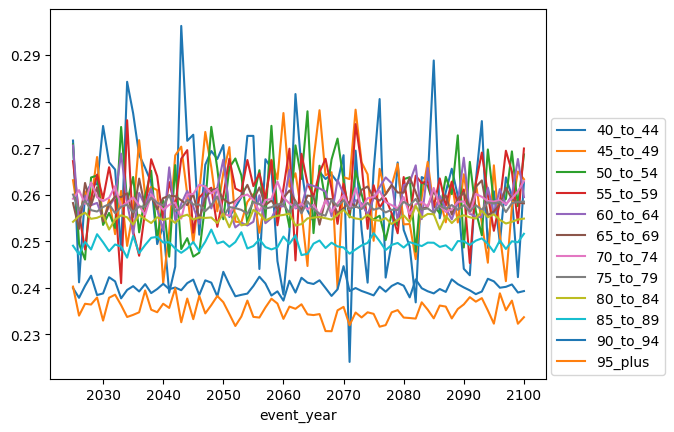

In [164]:
t = out_rates['alzheimers_mild_cognitive_impairment_state'].unstack()
t.loc['Sweden'].iloc[:,3:].plot()
plt.legend(loc=(1.01, .01));

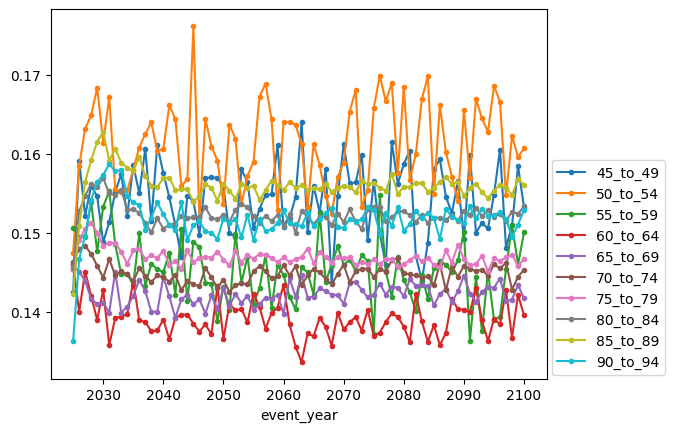

In [165]:
t = out_rates['alzheimers_blood_based_biomarker_state'].unstack()
t.loc['Sweden'].iloc[:,4:14].plot(marker='.')
plt.legend(loc=(1.01, .01));

In [166]:
# prevalence \approx incidence * duration
prevalence_count = person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()

mci_duration_est = (
    prevalence_count['alzheimers_mild_cognitive_impairment_state']
    / out_counts['alzheimers_blood_based_biomarker_state']
)
mci_duration_est

/tmp/ipykernel_1137157/1452923819.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prevalence_count = person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()


location  event_year  age_group
Sweden    2025        25_to_29          NaN
                      30_to_34     6.003922
                      35_to_39     3.225509
                      40_to_44     2.663195
                      45_to_49     2.183786
                                     ...   
          2100        75_to_79     4.714976
                      80_to_84     5.160438
                      85_to_89     5.873072
                      90_to_94     6.661860
                      95_plus      7.581824
Length: 1140, dtype: float64

In [167]:
new_sims = load_df('counts_new_simulants').groupby(['location', 'event_year', 'age_group', ]).value.sum()
# new_sims


bbbm_duration_est = (
    prevalence_count['alzheimers_blood_based_biomarker_state']
    / new_sims
)
bbbm_duration_est

/tmp/ipykernel_1137157/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()
/tmp/ipykernel_1137157/555533763.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  new_sims = load_df('counts_new_simulants').groupby(['location', 'event_year', 'age_group', ]).value.sum()


location  event_year  age_group
Sweden    2025        25_to_29             NaN
                      30_to_34             inf
                      35_to_39     1594.026010
                      40_to_44        0.973915
                      45_to_49       10.679058
                                      ...     
          2100        75_to_79        2.615648
                      80_to_84        3.729407
                      85_to_89        4.725397
                      90_to_94        3.671382
                      95_plus              inf
Length: 1140, dtype: float64

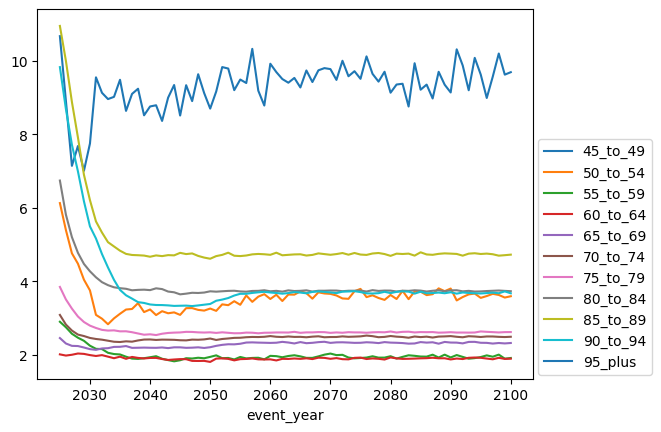

In [168]:
t = bbbm_duration_est.unstack()
t.loc['Sweden'].iloc[:, 4:].plot()
plt.legend(loc=(1.01, .01));

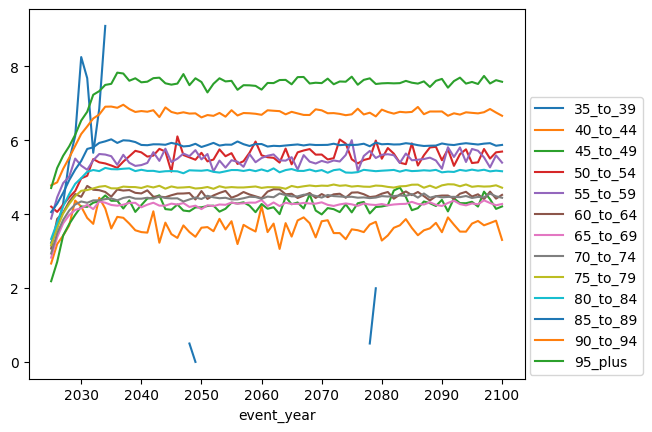

In [169]:
t = mci_duration_est.unstack()
t.loc['Sweden'].iloc[:, 2:].plot()
plt.legend(loc=(1.01, .01));

## Verify Other Cause Mortality in  Sim against artifact (ACMR - CSMR)

In [170]:
%%time

cols = ['input_draw','event_year','location','age_group','sex']

def calculate_ocmr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time_total.groupby(cols).sum(numeric_only=True)

    deaths = load_df('deaths')
    other_deaths = deaths[deaths.sub_entity == 'other_causes'].groupby(cols).sum(numeric_only=True)

    ocmr = (other_deaths / total_pt)[['value']].reset_index()

    ocmr2 = ocmr.merge(age_dictionary, on=['age_group'])
    ocmr3 = ocmr2.loc[ocmr2['age_group_id']#.isin(age_group_ids)
                     ]
    ocmr4 = ocmr2.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return ocmr4

sim_ocmr = calculate_ocmr()

/tmp/ipykernel_1137157/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()
<timed exec>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_1137157/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()
<timed exec>:8: FutureWarning: The default of observed=False is deprecated and wil

CPU times: user 37.3 s, sys: 7.96 s, total: 45.3 s
Wall time: 35.1 s


In [171]:
art_ocmr = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    
    # TODO: consider better ways to broadcast years from excess mx
    a = art.load(f'cause.all_causes.cause_specific_mortality_rate')
    b = art.load(f'cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate')

    data1 = (a - b.droplevel(['year_start', 'year_end'])).dropna()
    data2 = (data1.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
            .filter(['mean', '2.5%', '97.5%']).reset_index())
    data3 = data2.merge(age_dictionary, on=['age_start','age_end'])
    data4 = data3#.loc[data3['age_group_id'].isin(age_group_ids)]
    data4['measure'] = 'acmr'
    data4['location'] = locations[artifact_dirs.index(artifact_dir)].title()
    art_ocmr = pd.concat([art_ocmr, data4])
art_ocmr

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,Unnamed: 0,age_group_id,age_group_name,age_group,measure,location
0,Female,5.0,10.0,2022,2023,0.000056,0.000049,0.000070,6,6,5 to 9,5_to_9,acmr,Sweden
1,Female,5.0,10.0,2023,2024,0.000055,0.000047,0.000069,6,6,5 to 9,5_to_9,acmr,Sweden
2,Female,5.0,10.0,2024,2025,0.000054,0.000046,0.000069,6,6,5 to 9,5_to_9,acmr,Sweden
3,Female,5.0,10.0,2025,2026,0.000053,0.000045,0.000068,6,6,5 to 9,5_to_9,acmr,Sweden
4,Female,5.0,10.0,2026,2027,0.000053,0.000044,0.000068,6,6,5 to 9,5_to_9,acmr,Sweden
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,Male,95.0,125.0,2046,2047,0.177785,0.127205,0.219768,24,235,95 plus,95_plus,acmr,Sweden
1098,Male,95.0,125.0,2047,2048,0.177683,0.128545,0.221186,24,235,95 plus,95_plus,acmr,Sweden
1099,Male,95.0,125.0,2048,2049,0.177818,0.127315,0.220385,24,235,95 plus,95_plus,acmr,Sweden
1100,Male,95.0,125.0,2049,2050,0.178105,0.127624,0.221148,24,235,95 plus,95_plus,acmr,Sweden


In [172]:
art_data = art_ocmr
location = 'Sweden'
sex='Female'
year=2030
# art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]

In [173]:
def age_group_plot(measure, sim_data, art_data, art_year=None):
    for location in sim_data.location.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
        for i, year in enumerate([2030,2040,2050]):
            for j, sex in enumerate(sim_data.sex.unique()):
                color = f'C{j}'
                plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.event_year == year) & (sim_data.sex == sex)]
                if art_year is None:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]
                else:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == art_year)]

                ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
                ax[i].fill_between(art_plot.age_start, art_plot['2.5%'], art_plot['97.5%'], alpha=0.2, color=color)

                ax[i].plot(art_plot.age_start, art_plot['mean'], linestyle='--', label=f'Artifact {sex}', color=color, linewidth=3)
                ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}', color=color)

                if i == 0:
                    ax[i].set_title(f"{measure} in {location}")

                ax[i].text(.5, .95, f"{year}", va='top', ha='center', transform=ax[i].transAxes)
#                 ax[i].tick_params(axis='x', labelrotation=90)
                
                if i == 2:
                    ax[i].set_xlabel("Age Group")
                    
                if i == 1:
                    ax[i].set_ylabel(f"{measure}")
                    ax[i].legend(loc=(1.01, 0))
#                 ax[i].semilogy()
        plt.subplots_adjust(hspace=0)


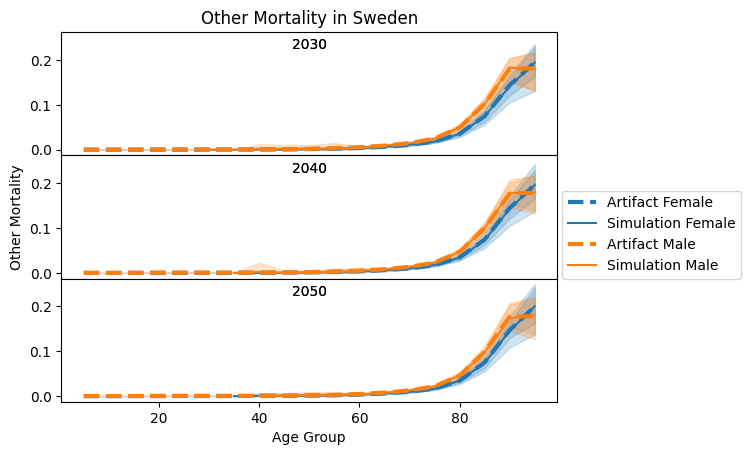

In [174]:
age_group_plot('Other Mortality', sim_ocmr, art_ocmr)

In [175]:
def over_time_plot(measure, sim_data, age_start):
    for location in sim_data.location.unique():
        for sex in sim_data.sex.unique():
            plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.age_start == age_start) & (sim_data.sex == sex)]

            plt.plot(plot_data.event_year, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.event_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.title(f"{measure} in {location} Over Time Among Age Start Group {age_start}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Year")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

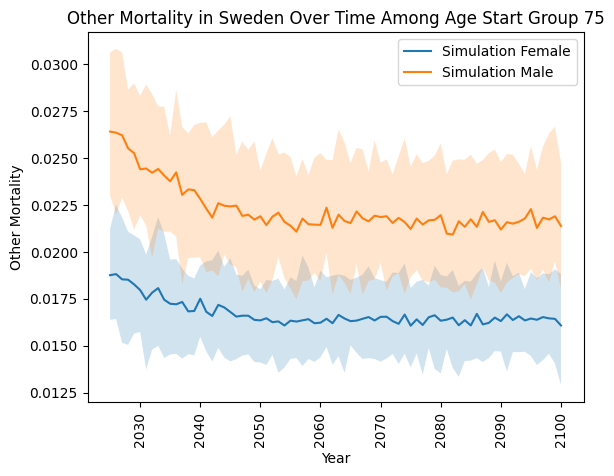

<Figure size 640x480 with 0 Axes>

In [176]:
over_time_plot('Other Mortality', sim_ocmr, 75)

## Validate Alzheimer’s EMR against GBD

In [177]:
cols = ['input_draw','event_year','location','age_group','sex']

def calculate_emr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    infected = person_time_total.loc[
        person_time_total.sub_entity == 'alzheimers_disease_state'
    ].groupby(cols).sum(numeric_only=True)
    assert len(infected) > 0

    deaths0 = load_df('deaths')
    deaths = deaths0.loc[
        deaths0.sub_entity == 'alzheimers_disease_state'
    ].groupby(cols).sum(numeric_only=True)
    assert len(deaths) > 0
    
    mr = (deaths / infected)[['value']].reset_index()

    mr = mr.merge(age_dictionary, on=['age_group'])
    mr = mr.loc[mr['age_group_id'].isin(age_group_ids)]
    mr1 = mr.groupby([c for c in cols if c != 'input_draw'] + ['age_start']
                    ).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return mr1

sim_emr = calculate_emr()

/tmp/ipykernel_1137157/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()
/tmp/ipykernel_1137157/982211503.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ].groupby(cols).sum(numeric_only=True)
/tmp/ipykernel_1137157/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()
/tmp/ipykernel_113

In [178]:
def load_artifact_cause_data(measure):
    out = pd.DataFrame()
    for artifact_dir in artifact_dirs:
        art = Artifact(artifact_dir, filter_terms = ['year_start==2021'])
        data = art.load(f'cause.alzheimers_disease_and_other_dementias.{measure}')
        data = (data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
                .filter(['mean', '2.5%', '97.5%']).reset_index())
        data = data.merge(age_dictionary, on=['age_start','age_end'])
#         data = data.loc[data['age_group_id'].isin(age_group_ids)]
        data['measure'] = measure
        data['location'] = locations[artifact_dirs.index(artifact_dir)].title()
        out = pd.concat([out, data])
    return out

In [179]:
art_emr = load_artifact_cause_data('excess_mortality_rate')
# art_emr

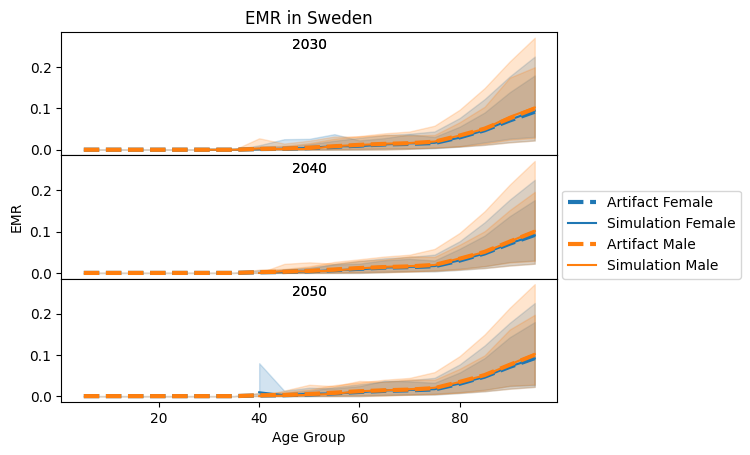

In [180]:
age_group_plot('EMR', sim_emr, art_emr, art_year=2021)

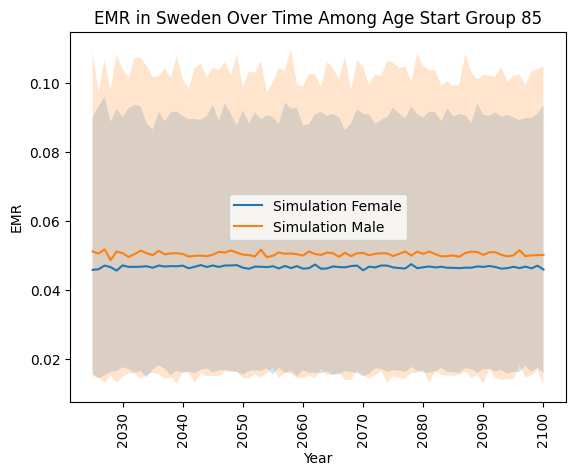

<Figure size 640x480 with 0 Axes>

In [181]:
over_time_plot('EMR', sim_emr, 85)

## Verify the number of new simulants per year against the AD population model

In [182]:
art.keys

['metadata.keyspace',
 'metadata.locations',
 'population.location',
 'population.structure',
 'population.age_bins',
 'population.demographic_dimensions',
 'population.theoretical_minimum_risk_life_expectancy',
 'cause.all_causes.cause_specific_mortality_rate',
 'covariate.live_births_by_sex.estimate',
 'population.scaling_factor',
 'cause.alzheimers.prevalence',
 'cause.alzheimers.bbbm_conditional_prevalence',
 'cause.alzheimers.mci_conditional_prevalence',
 'cause.alzheimers.mci_to_dementia_transition_rate',
 'cause.alzheimers.susceptible_to_bbbm_transition_count',
 'cause.alzheimers.population_incidence_rate',
 'cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate',
 'cause.alzheimers_disease_and_other_dementias.excess_mortality_rate',
 'cause.alzheimers_disease_and_other_dementias.disability_weight',
 'cause.alzheimers.mci_disability_weight',
 'cause.alzheimers_disease_and_other_dementias.restrictions',
 'testing_rates.csf',
 'testing_rates.pet',
 'treatment.

In [183]:
art_incidence_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'cause.alzheimers.population_incidence_rate'
        ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    art_incidence_data.append(df)
    
art_incidence_data = pd.concat(art_incidence_data)
for i in range(500):
    art_incidence_data[f'draw_{i}'] *= art_incidence_data[f'draw_{i}_pop']
    del art_incidence_data[f'draw_{i}_pop']
    

In [184]:
scale = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    temp = art.load('population.structure').reset_index() 
    temp['location'] = temp.location.str.replace(' ', '_').str.title()
#     import pdb; pdb.set_trace()
    df_prev_pop = pd.merge(
        art.load('population.scaling_factor').query("year_start == 2023"),
        art.load('population.structure').query("year_start==2025").droplevel(['year_start', 'year_end']),
        left_index=True,
        right_index=True,
        suffixes=['_prev', '_pop']
    )
    prev = ((df_prev_pop.filter(like='draw_').filter(like='_prev')
            * df_prev_pop.filter(like='draw_').filter(like='_pop').values).mean(axis=1)).sum(axis=0)
    # TODO: use draw-specific scale instead of mean

    ratio = 100_000 / (prev+.01)
    temp['ratio'] = ratio

    temp = temp.rename(columns={'year_start': 'event_year'})
    temp = temp.merge(age_dictionary, on=['age_start','age_end'])
    temp = temp.loc[temp['age_group_id'].isin(age_group_ids)]
    scale = pd.concat([scale, temp], ignore_index=True)
# scale

In [185]:
scale.groupby('location').ratio.describe()/5  # compare to 0.0035494897066482814 in interactive sim for USA

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
Sweden,168.0,0.112504,0.0,0.112504,0.112504,0.112504,0.112504,0.112504


In [186]:
cols = ['input_draw','event_year','location','age_group','sex']

new_sims = load_df('counts_new_simulants')
# new_sims

/tmp/ipykernel_1137157/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()


In [187]:
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
new_ad_dementia = trans[trans.sub_entity == 'alzheimers_mild_cognitive_impairment_state_to_alzheimers_disease_state']

/tmp/ipykernel_1137157/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()


In [188]:
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','event_year']])
new_ad_dementia = new_ad_dementia.merge(scale[['location','sex','age_group','ratio','event_year']])

In [189]:
# new_sims

In [190]:
new_sims['total_incidence'] = new_sims['value'] / new_sims['ratio']
new_ad_dementia['total_incidence'] = new_ad_dementia['value'] / new_sims['ratio']

def summarize(df):
    df = df.groupby(cols).sum(numeric_only=True)
    df = df.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_incidence'].reset_index()

    df = df.merge(age_dictionary, on=['age_group'])
    df = df.loc[df['age_group_id'].isin(age_group_ids)]

    return df

new_sims_summary = summarize(new_sims)

In [191]:
new_ad_dementia_summary = summarize(new_ad_dementia)
new_ad_dementia_summary

,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
0,2025,Sweden,30_to_34,Female,25.0,10.595220,7.391987,3.555443,3.555443,8.888607,26.310277,28.443543,11,11,30 to 34,30.0,35.0
1,2025,Sweden,30_to_34,Male,25.0,5.688709,3.736036,0.000000,1.066633,5.333164,13.155139,14.221772,11,11,30 to 34,30.0,35.0
2,2025,Sweden,35_to_39,Female,25.0,8.319736,4.096481,1.777721,2.844354,7.110886,15.999493,15.999493,12,12,35 to 39,35.0,40.0
3,2025,Sweden,35_to_39,Male,25.0,3.128790,2.580249,0.000000,0.000000,1.777721,8.177519,12.444050,12,12,35 to 39,35.0,40.0
4,2025,Sweden,40_to_44,Female,25.0,8.035301,3.408716,1.777721,2.844354,7.110886,14.577316,17.777215,13,13,40 to 44,40.0,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,2050,Sweden,85_to_89,Male,25.0,1028.376304,197.910864,732.421237,777.219818,1032.856163,1393.022528,1450.620703,22,31,85 to 89,85.0,90.0
724,2050,Sweden,90_to_94,Female,25.0,1144.568178,153.110984,965.302747,972.769178,1114.631349,1451.331792,1564.394876,23,32,90 to 94,90.0,95.0
725,2050,Sweden,90_to_94,Male,25.0,498.117550,61.137854,394.654162,401.053959,510.206056,644.957342,647.090608,23,32,90 to 94,90.0,95.0
726,2050,Sweden,95_plus,Female,25.0,472.020599,119.276499,254.214167,270.213660,474.651627,680.511771,682.645037,24,235,95 plus,95.0,125.0


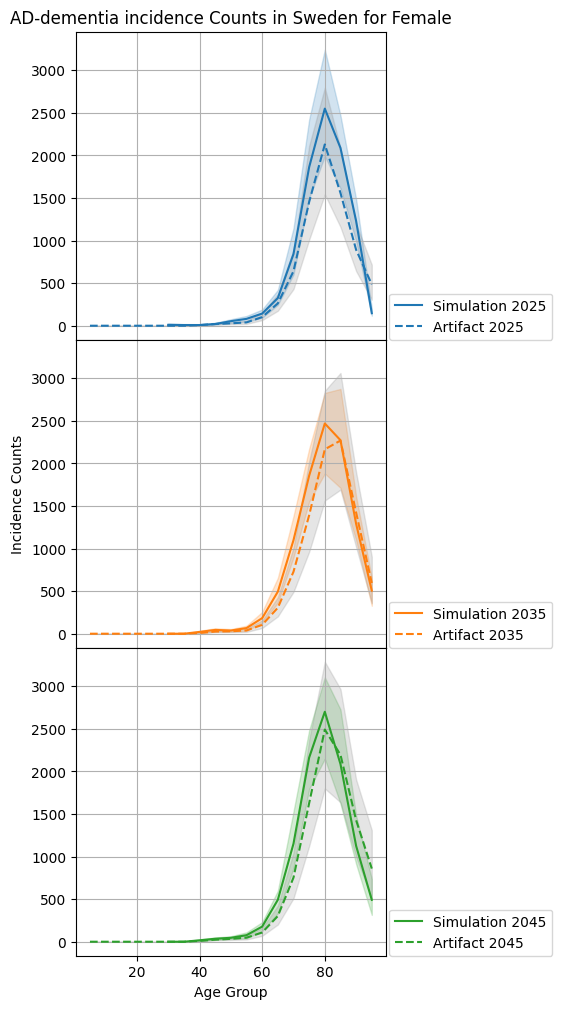

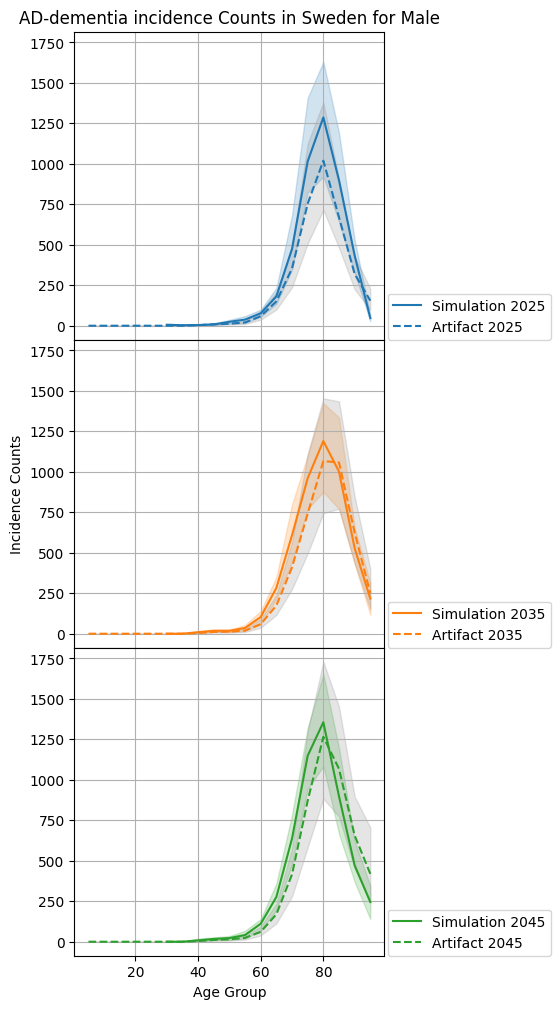

In [192]:
for location in new_sims.location.unique():
    for sex in new_sims.sex.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(4,12))
        plt.subplots_adjust(hspace=0)
        for i, year in enumerate([2025, 2035, 2045]):
            color = f'C{i}'
            plot_data = new_ad_dementia_summary.query('location == @location and event_year == @year and sex == @sex')

            location_w_spaces = location.replace('_', ' ').replace('Of', 'of')
            art_plot = art_incidence_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()

            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
            ax[i].fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2, color='grey')
            ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {year}', color=color)
            ax[i].plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {year}', color=color, linestyle='--')
            ax[i].grid(True)
            if i == 0:
                ax[i].set_title(f"AD-dementia incidence Counts in {location} for {sex}")
#             plt.tick_params(axis='x', labelrotation=90)
            ax[i].set_xlabel("Age Group")
            if i == 1:
                ax[i].set_ylabel(f"Incidence Counts")
            ax[i].legend(loc=(1.01, 0))

#             ax[i].semilogy()

## Verifying Overall Prevalence

In [205]:
art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'population.scaling_factor'
                ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    art_prev_data.append(df)
    
art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f'draw_{i}'] *= art_prev_data[f'draw_{i}_pop']
    del art_prev_data[f'draw_{i}_pop']
art_prev_data

draw_0  \
sex    age_start age_end location year_start year_end                
Female 5.0       10.0    Sweden   2021       2022         0.000000   
                                  2022       2023         0.000000   
                                  2023       2024         0.000000   
                                  2024       2025         0.000000   
                                  2025       2026         0.000000   
...                                                            ...   
Male   95.0      125.0   Sweden   2046       2047      7209.481407   
                                  2047       2048      7213.221738   
                                  2048       2049      7215.109626   
                                  2049       2050      7203.743213   
                                  2050       2051      7182.421146   

                                                            draw_1  \
sex    age_start age_end location year_start year_end                
Female 5.0       10.0    Sweden   2021       2022         0.000000   
                                  2022       2023         0.000000   
                                  2023       2024         0.000000   
                                  2024       2025         0.000000   
                                  2025       2026         0.000000   
...                                                            ...   
Male   95.0      125.0   Sweden   2046       2047      5174.926714   
                                  2047       2048      5187.295995   
                                  2048       2049      5177.580890   
                                  2049       2050      5157.706281   
                                  2050       2051      5151.157943   

                                                            draw_2  \
sex    age_start age_end location year_start year_end                
Female 5.0       10.0    Sweden   2021       2022         0.000000   
                                  2022       2023         0.000000   
                                  2023       2024         0.000000   
                                  2024       2025         0.000000   
                                  2025       2026         0.000000   
...                                                            ...   
Male   95.0      125.0   Sweden   2046       2047      5798.700616   
                                  2047       2048      5817.662415   
                                  2048       2049      5831.536579   
                                  2049       2050      5845.717677   
                                  2050       2051      5854.442183   

                                                            draw_3  \
sex    age_start age_end location year_start year_end                
Female 5.0       10.0    Sweden   2021       2022         0.000000   
                                  2022       2023         0.000000   
                                  2023       2024         0.000000   
                                  2024       2025         0.000000   
                                  2025       2026         0.000000   
...                                                            ...   
Male   95.0      125.0   Sweden   2046       2047      7428.965841   
                                  2047       2048      7501.843151   
                                  2048       2049      7539.181226   
                                  2049       2050      7566.810431   
                                  2050       2051      7619.901777   

                                                            draw_4  \
sex    age_start age_end location year_start year_end                
Female 5.0       10.0    Sweden   2021       2022         0.000000   
                                  2022       2023         0.000000   
                                  2023       2024         0.000000   
                                  2024       2025         0.000000

In [206]:
cols = ['input_draw','event_year','location','age_group','sex']

new_sims = load_df('person_time_alzheimers_disease_and_other_dementias')
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','event_year']])
new_sims['total_prev'] = new_sims['value'] / new_sims['ratio']
new_sims = new_sims.groupby(cols).sum(numeric_only=True)
new_sims = new_sims.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_prev'].reset_index()

new_sims = new_sims.merge(age_dictionary, on=['age_group'])
new_sims = new_sims.loc[new_sims['age_group_id'].isin(age_group_ids)]
new_sims.tail()

/tmp/ipykernel_1137157/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()


,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
723,2050,Sweden,85_to_89,Male,25.0,19694.018843,2809.079415,16363.730046,16453.552069,18918.431365,25984.430490,26944.835195,22,31,85 to 89,85.0,90.0
724,2050,Sweden,90_to_94,Female,25.0,25179.221232,3329.869678,19245.298489,19455.769028,25238.748253,31246.725445,32637.106579,23,32,90 to 94,90.0,95.0
725,2050,Sweden,90_to_94,Male,25.0,10173.415920,1547.162677,6839.406685,7914.082011,10047.842252,13024.547630,13237.675625,23,32,90 to 94,90.0,95.0
726,2050,Sweden,95_plus,Female,25.0,12801.215003,2425.849158,8370.101511,9027.024707,13444.071397,17208.269657,18495.009995,24,235,95 plus,95.0,125.0
727,2050,Sweden,95_plus,Male,25.0,5649.291458,1402.314922,3494.555028,3621.049948,5463.730143,8237.583024,8243.429427,24,235,95 plus,95.0,125.0


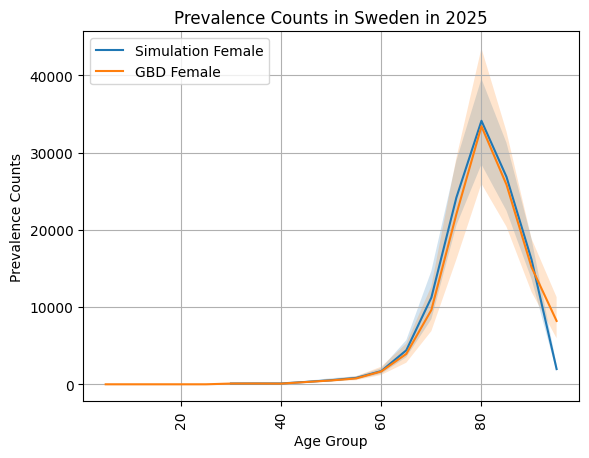

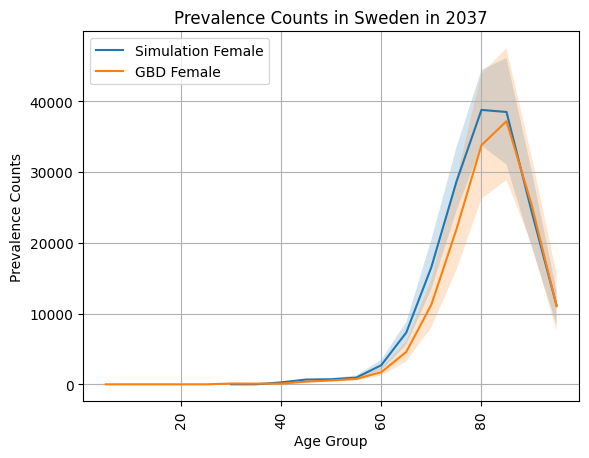

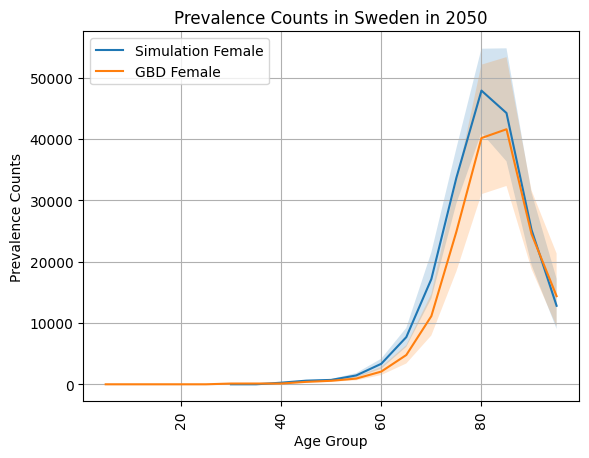

<Figure size 640x480 with 0 Axes>

In [207]:
for location in new_sims.location.unique():
    for year in [2025,2037,2050]:
        for sex in new_sims.sex.unique()[:1]:
            plot_data = new_sims.loc[(new_sims.location == location) & (new_sims.event_year == year) & (new_sims.sex == sex) ]
#             gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            location_w_spaces = location.replace('_', ' ').replace('Of', 'of')
            art_plot = art_prev_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.plot(art_plot.age_start, art_plot['mean'], label=f'GBD {sex}')
            plt.fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2)

            plt.title(f"Prevalence Counts in {location} in {year}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Prevalence Counts")
            plt.legend()
            plt.grid()
#             plt.semilogy()
        plt.figure()

# Dementia Prevalence

In [223]:
# swtich from this
# art.load(
#     'population.scaling_factor'
#         )#.droplevel(['year_start', 'year_end'])

# to this
# art.load(
#     'cause.alzheimers.prevalence'
#         )#.droplevel(['year_start', 'year_end'])

# ?

In [224]:
art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'cause.alzheimers.prevalence'
                ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    art_prev_data.append(df)
    
art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f'draw_{i}'] *= art_prev_data[f'draw_{i}_pop']
    del art_prev_data[f'draw_{i}_pop']

    
art_prev_data

draw_0  \
sex    age_start age_end location year_start year_end                
Female 5.0       10.0    Sweden   2021       2022         0.000000   
                                  2022       2023         0.000000   
                                  2023       2024         0.000000   
                                  2024       2025         0.000000   
                                  2025       2026         0.000000   
...                                                            ...   
Male   95.0      125.0   Sweden   2046       2047      2511.232006   
                                  2047       2048      2512.534852   
                                  2048       2049      2513.192448   
                                  2049       2050      2509.233258   
                                  2050       2051      2501.806281   

                                                            draw_1  \
sex    age_start age_end location year_start year_end                
Female 5.0       10.0    Sweden   2021       2022         0.000000   
                                  2022       2023         0.000000   
                                  2023       2024         0.000000   
                                  2024       2025         0.000000   
                                  2025       2026         0.000000   
...                                                            ...   
Male   95.0      125.0   Sweden   2046       2047      1921.989629   
                                  2047       2048      1926.583632   
                                  2048       2049      1922.975401   
                                  2049       2050      1915.593887   
                                  2050       2051      1913.161807   

                                                            draw_2  \
sex    age_start age_end location year_start year_end                
Female 5.0       10.0    Sweden   2021       2022         0.000000   
                                  2022       2023         0.000000   
                                  2023       2024         0.000000   
                                  2024       2025         0.000000   
                                  2025       2026         0.000000   
...                                                            ...   
Male   95.0      125.0   Sweden   2046       2047      2277.096103   
                                  2047       2048      2284.542226   
                                  2048       2049      2289.990482   
                                  2049       2050      2295.559268   
                                  2050       2051      2298.985301   

                                                            draw_3  \
sex    age_start age_end location year_start year_end                
Female 5.0       10.0    Sweden   2021       2022         0.000000   
                                  2022       2023         0.000000   
                                  2023       2024         0.000000   
                                  2024       2025         0.000000   
                                  2025       2026         0.000000   
...                                                            ...   
Male   95.0      125.0   Sweden   2046       2047      2586.841860   
                                  2047       2048      2612.218484   
                                  2048       2049      2625.219984   
                                  2049       2050      2634.840755   
                                  2050       2051      2653.327705   

                                                            draw_4  \
sex    age_start age_end location year_start year_end                
Female 5.0       10.0    Sweden   2021       2022         0.000000   
                                  2022       2023         0.000000   
                                  2023       2024         0.000000   
                                  2024       2025         0.000000

In [225]:
# t[t.sub_entity == 'alzheimers_disease_state']

In [226]:
cols = ['input_draw','event_year','location','age_group','sex']

new_sims = load_df('person_time_alzheimers_disease_and_other_dementias')

# restrict to dementia state only
new_sims = new_sims[new_sims.sub_entity == 'alzheimers_disease_state']

new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','event_year']])
new_sims['total_prev'] = new_sims['value'] / new_sims['ratio']
new_sims = new_sims.groupby(cols).sum(numeric_only=True)
new_sims = new_sims.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_prev'].reset_index()

new_sims = new_sims.merge(age_dictionary, on=['age_group'])
new_sims = new_sims.loc[new_sims['age_group_id'].isin(age_group_ids)]
new_sims.tail()

/tmp/ipykernel_1137157/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()


,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
723,2050,Sweden,85_to_89,Male,25.0,10905.633711,1595.111006,8367.444055,8735.236006,10686.517581,14336.268057,14938.447654,22,31,85 to 89,85.0,90.0
724,2050,Sweden,90_to_94,Female,25.0,15926.631635,2603.625355,11688.378605,11857.924316,15998.772715,20542.491489,22400.584930,23,32,90 to 94,90.0,95.0
725,2050,Sweden,90_to_94,Male,25.0,5961.241394,1261.966636,3449.378271,4132.344539,5701.129572,8597.756933,8603.071846,23,32,90 to 94,90.0,95.0
726,2050,Sweden,95_plus,Female,25.0,9171.023405,2196.186002,5702.901209,5897.958501,9517.236812,12986.988914,13824.087647,24,235,95 plus,95.0,125.0
727,2050,Sweden,95_plus,Male,25.0,3682.419472,1177.238750,1789.353905,2166.712699,3158.829716,5758.353464,5893.352244,24,235,95 plus,95.0,125.0


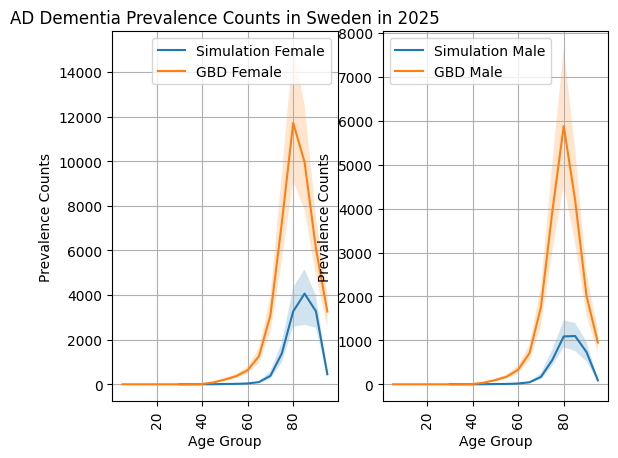

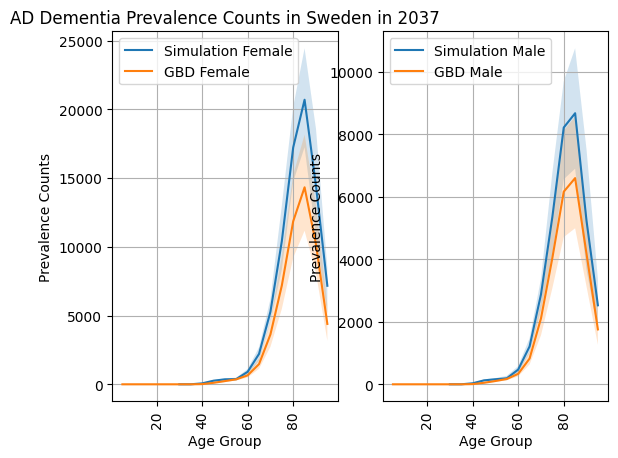

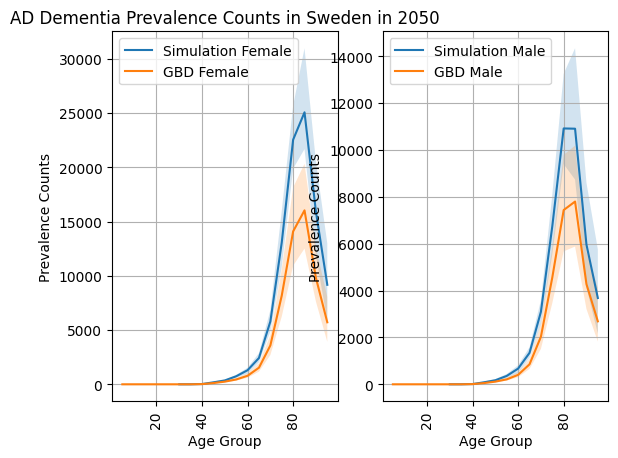

<Figure size 640x480 with 0 Axes>

In [231]:
for location in new_sims.location.unique():
    for year in [2025,2037,2050]:
        for i, sex in enumerate(new_sims.sex.unique()):
            plt.subplot(1,2,i+1)
            plot_data = new_sims.loc[(new_sims.location == location) & (new_sims.event_year == year) & (new_sims.sex == sex) ]
#             gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            location_w_spaces = location.replace('_', ' ').replace('Of', 'of')
            art_plot = art_prev_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.plot(art_plot.age_start, art_plot['mean'], label=f'GBD {sex}')
            plt.fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2)

            if i == 0:
                plt.title(f"AD Dementia Prevalence Counts in {location} in {year}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Prevalence Counts")
            plt.legend()
            plt.grid()
#             plt.semilogy()
        plt.figure()

## Total Sim Population Over Time

In [203]:
cols = ['input_draw','event_year','location'] #, 'age_group']

person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time_total = person_time_total.groupby(cols)['value'].sum().reset_index()
person_time_total = person_time_total.groupby([c for c in cols if c != 'input_draw'])['value'].describe(percentiles=[0.025,0.975]).reset_index()
person_time_total#.head()

/tmp/ipykernel_1137157/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()


,event_year,location,count,mean,std,min,2.5%,50%,97.5%,max
0,2025,Sweden,25.0,101130.570951,271.370681,100612.988364,100641.390828,101067.427789,101713.309788,101775.496235
1,2026,Sweden,25.0,106688.444846,1351.523185,104138.381930,104325.240246,106579.997262,109430.807392,109866.710472
2,2027,Sweden,25.0,111717.135989,2402.294079,107133.596167,107485.487748,111612.714579,116353.833265,117489.034908
3,2028,Sweden,25.0,116208.731554,3427.565650,109859.734428,110273.812457,116228.862423,122771.594251,124785.478439
4,2029,Sweden,25.0,120190.976263,4305.010458,112454.822724,112830.931143,119828.501027,128532.211910,131268.714579
...,...,...,...,...,...,...,...,...,...,...
71,2096,Sweden,25.0,172526.632170,13722.743156,154798.412047,154877.639973,169930.447639,203000.781930,216405.848049
72,2097,Sweden,25.0,172464.864285,13695.628552,154684.802190,154869.567693,169892.079398,202929.227652,216277.787817
73,2098,Sweden,25.0,172447.643422,13657.043466,154704.235455,154938.630527,169926.461328,202747.651198,216218.491444
74,2099,Sweden,25.0,172422.788775,13654.009636,154604.577687,154981.881999,169818.332649,202632.845448,216222.976044


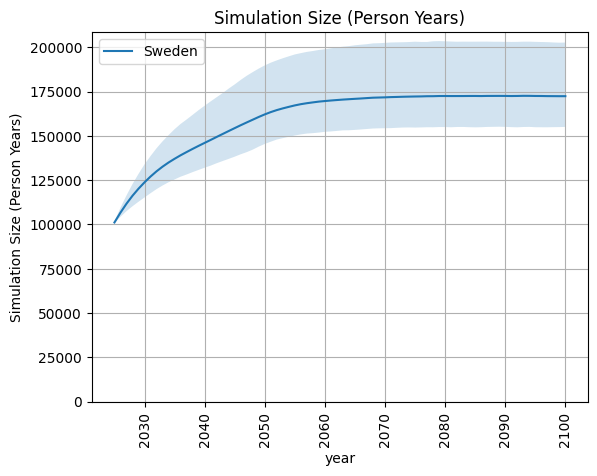

In [204]:
for location in person_time_total.location.unique():
    plot_data = person_time_total.loc[(person_time_total.location == location)]
    plt.plot(plot_data.event_year, plot_data['mean'], label=location)
    plt.fill_between(plot_data.event_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)
    plt.title(f"Simulation Size (Person Years)")
    plt.tick_params(axis='x', labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()
    plt.axis(ymin=0)
    plt.grid()

# Decompose person-time by state

In [200]:
cols = ['input_draw','event_year', 'sub_entity', 'location'] #, 'age_group']

person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time_total = person_time_total.groupby(cols)['value'].sum().reset_index()
person_time_total = person_time_total.groupby([c for c in cols if c != 'input_draw'])['value'].describe(percentiles=[0.025,0.975]).reset_index()
person_time_total#.head()

/tmp/ipykernel_1137157/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()
/tmp/ipykernel_1137157/1445989731.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time_total = person_time_total.groupby(cols)['value'].sum().reset_index()
/tmp/ipykernel_1137157/1445989731.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time_total = person_tim

,event_year,sub_entity,location,count,mean,std,min,2.5%,50%,97.5%,max
0,2025,alzheimers_blood_based_biomarker_state,Sweden,25.0,60876.884764,767.279653,59514.124572,59584.383299,60912.821355,62068.552498,62076.325804
1,2025,alzheimers_disease_state,Sweden,25.0,9461.508556,660.512295,8374.242300,8468.119918,9343.414100,10739.320465,11105.861739
2,2025,alzheimers_mild_cognitive_impairment_state,Sweden,25.0,30792.177632,603.810534,29917.262149,30024.593566,30574.006845,32142.520465,32380.802190
3,2026,alzheimers_blood_based_biomarker_state,Sweden,25.0,56707.263518,1187.145474,54442.540726,54732.245859,56669.393566,58567.475428,59094.565366
4,2026,alzheimers_disease_state,Sweden,25.0,16618.311622,600.876075,15833.127995,15914.747707,16318.461328,17853.988227,18249.828884
...,...,...,...,...,...,...,...,...,...,...,...
223,2099,alzheimers_disease_state,Sweden,25.0,86867.371718,9736.172909,72597.196441,72882.416975,84823.709788,107152.929774,113843.055441
224,2099,alzheimers_mild_cognitive_impairment_state,Sweden,25.0,37758.195866,2834.807361,31715.088296,32297.787269,37990.537988,43998.207255,44974.056126
225,2100,alzheimers_blood_based_biomarker_state,Sweden,25.0,47825.902697,3561.706904,39954.792608,41084.911704,47528.284736,55504.792882,57424.799452
226,2100,alzheimers_disease_state,Sweden,25.0,86886.565804,9727.333692,72678.915811,73010.477207,84864.569473,107301.320192,113658.688569


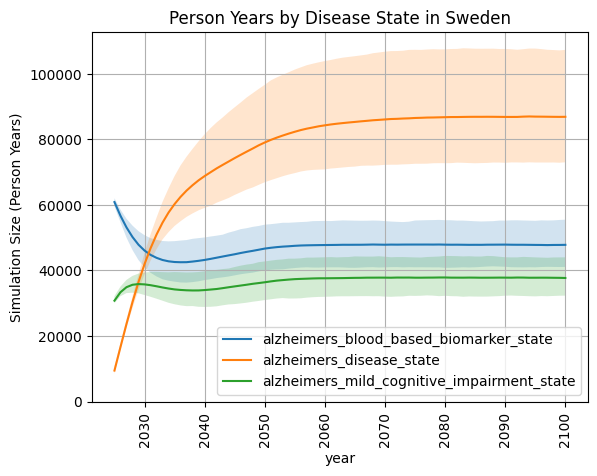

In [202]:
for location in person_time_total.location.unique():
    for sub_entity in person_time_total.sub_entity.unique():
        plot_data = person_time_total.query("location == @location and sub_entity == @sub_entity")
        plt.plot(plot_data.event_year, plot_data['mean'], label=sub_entity)
        plt.fill_between(plot_data.event_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)
    plt.title(f"Person Years by Disease State in {location}")
    plt.tick_params(axis='x', labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()
    plt.axis(ymin=0)
    plt.grid()

# Does this mean that excess mortality is too low??
# I don't think that is the main problem --- more important to figure out what the AD Dementia prevalence is missing its target on initialization
